In [39]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

plt.rc('font', family='Malgun Gothic')  # 폰트 지정
plt.rc('axes', unicode_minus=False)  # 마이너스 폰트 설정
%config InlineBackend.figure_format = 'retina'  # 그래프 글씨 뚜렷

import os
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

In [40]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [41]:
df_train = pd.read_csv("../data/preprocessed/df_train001.csv")

---

# 지수평활
    - 모든 시점의 데이터를 똑같이 취급하고 싶지 않을 때 사용
    - 특히, 최근에 측정된 데이터일수록 더 유익한 것으로서 다루고 싶을 때

## 단순한 지수평활
    - 예측 성능은 좋지 않음

In [43]:
Y = df_train[['일시','평균기온']]

In [51]:
Y['일시'] = pd.to_datetime(Y['일시'])

In [52]:
Y.head()

,일시,평균기온
0,1960-01-01,-1.6
1,1960-01-02,-1.9
2,1960-01-03,4.0
3,1960-01-04,7.5
4,1960-01-05,-4.6


In [53]:
Y['Smooth.5'] = Y.ewm(alpha=0.5).mean().평균기온
Y['Smooth.9'] = Y.ewm(alpha=0.9).mean().평균기온

In [57]:
Y.head()

,일시,평균기온,Smooth.5,Smooth.9
0,1960-01-01,-1.6,-1.600000,-1.600000
1,1960-01-02,-1.9,-1.800000,-1.872727
2,1960-01-03,4.0,1.514286,3.418018
3,1960-01-04,7.5,4.706667,7.092169
4,1960-01-05,-4.6,-0.096774,-3.430888


In [58]:
Y.set_index('일시', inplace=True)

In [59]:
Y.head()

,평균기온,Smooth.5,Smooth.9
일시,,,
1960-01-01,-1.6,-1.600000,-1.600000
1960-01-02,-1.9,-1.800000,-1.872727
1960-01-03,4.0,1.514286,3.418018
1960-01-04,7.5,4.706667,7.092169
1960-01-05,-4.6,-0.096774,-3.430888


### 평활요인(alpha) = 0.5

In [61]:
train_size = int(len(Y) * 0.8)
y_train, y_test = Y['Smooth.5'][:train_size], Y['Smooth.5'][train_size:]

In [62]:
# 모델 생성 및 학습
model = SARIMAX(y_train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12)) # p,d,q,s
result = model.fit()

In [63]:
pred = result.get_prediction(start=y_test.index[0], end=y_test.index[-1], dynamic=False)
pred_ci = pred.conf_int()

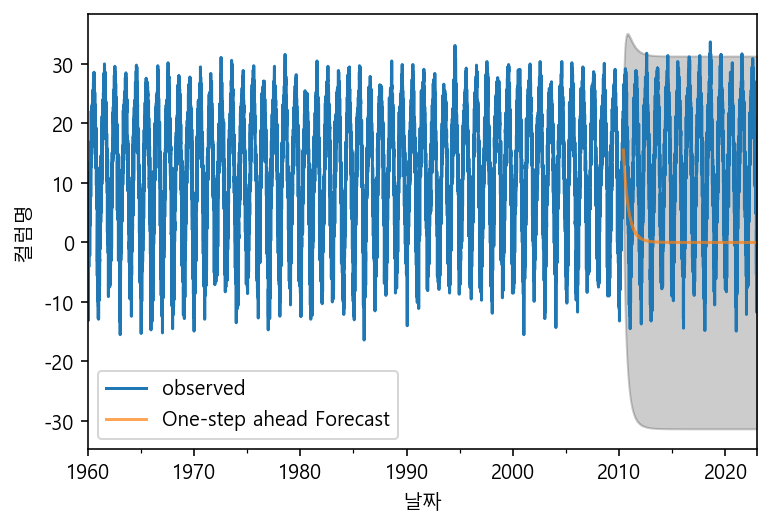

In [66]:
# 시각화
ax = Y['평균기온'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.7)
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=0.2)
ax.set_xlabel('날짜')
ax.set_ylabel('컬럼명')
plt.legend()
plt.show()

### 평활요인(alpha) = 0.9

In [67]:
train_size = int(len(Y) * 0.8)
y_train, y_test = Y['Smooth.9'][:train_size], Y['Smooth.9'][train_size:]

In [68]:
# 모델 생성 및 학습
model = SARIMAX(y_train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12)) # p,d,q,s
result = model.fit()

In [69]:
pred = result.get_prediction(start=y_test.index[0], end=y_test.index[-1], dynamic=False)
pred_ci = pred.conf_int()

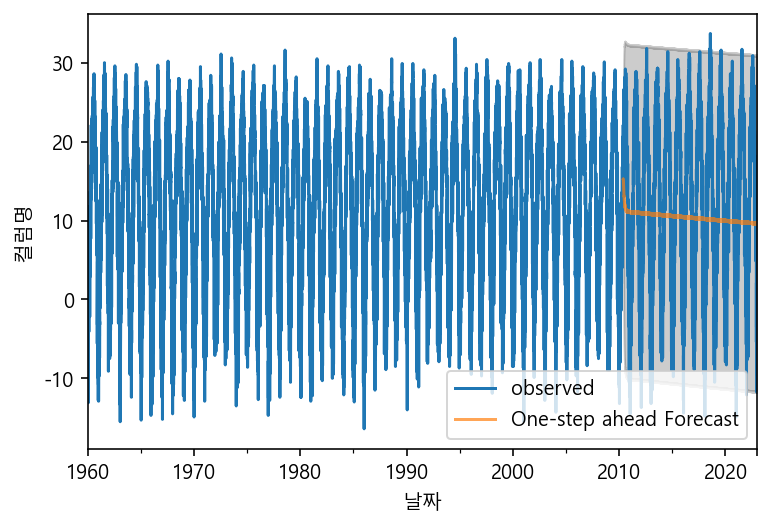

In [70]:
# 시각화
ax = Y['평균기온'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.7)
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=0.2)
ax.set_xlabel('날짜')
ax.set_ylabel('컬럼명')
plt.legend()
plt.show()

#### 제출

In [71]:
sub_file = pd.read_csv("../data/original/sample_submission.csv")

In [72]:
target = pd.to_datetime(sub_file['일시'])

In [73]:
pred = result.get_prediction(start=target.values[0], end=target.values[-1], dynamic=False)

In [74]:
sub_file['평균기온'] = pred.predicted_mean.values

In [76]:
sub_file.to_csv("../data/sub/003_SARIMAX_alpha_0.9.csv", index=False, encoding='utf-8')

---

In [77]:
import joblib

In [78]:
joblib.dump(result, '../model/sarimax_model_003.pkl')

['../model/sarimax_model_003.pkl']

In [79]:
loaded_model = joblib.load('../model/sarimax_model_003.pkl')

In [80]:
# 예측 수행 (불러온 모델로 예측 가능)
forecast = loaded_model.get_forecast(steps=10)

forecast.conf_int()

,lower Smooth.9,upper Smooth.9
2010-05-26,11.155083,19.342014
2010-05-27,8.687263,21.803643
2010-05-28,6.904087,23.352645
2010-05-29,5.464274,24.516173
2010-05-30,4.106232,25.311798
2010-05-31,3.187125,26.230830
2010-06-01,2.324032,26.967811
2010-06-02,1.483158,27.538827
2010-06-03,0.689928,28.003855
2010-06-04,0.074119,28.517890


## 홀트의 방법 | 홀트-윈터스
    - 추세와 계절성을 모두 고려

In [126]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [127]:
train_size = int(len(Y) * 0.8)
y_train, y_test = Y['평균기온'][:train_size], Y['평균기온'][train_size:]

In [128]:
# Holt's Exponential Smoothing 모델 학습
model = ExponentialSmoothing(y_train, trend=None, seasonal="add", seasonal_periods=12)
result = model.fit()

In [129]:
pred = result.predict(start=y_test.index[0], end=y_test.index[-1])

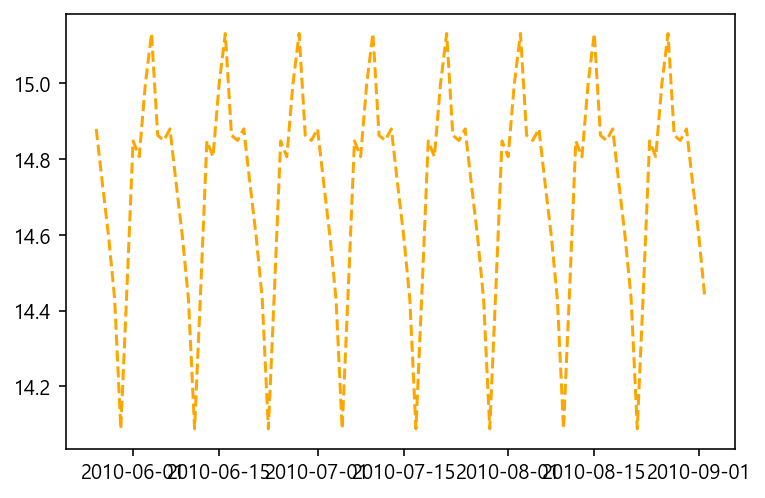

In [130]:
plt.plot(y_test.index[:100], pred[:100], label='Forecast', linestyle='--', color='orange')

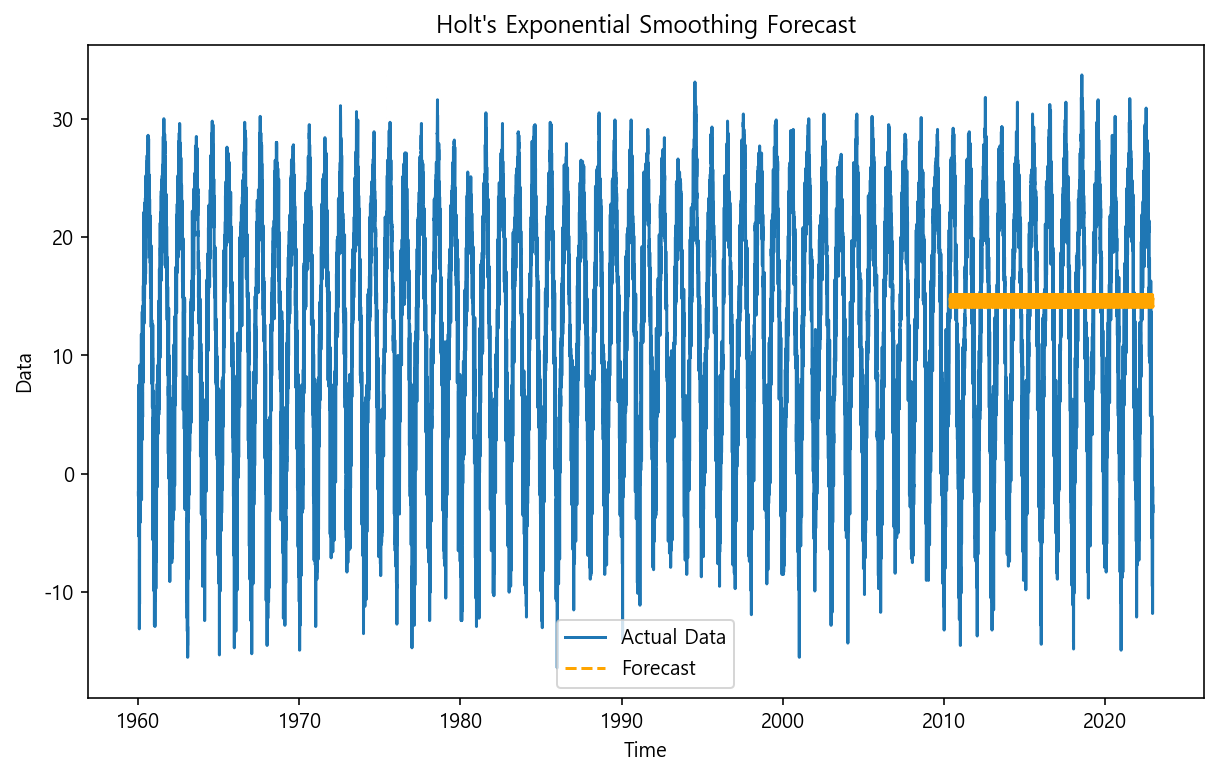

In [131]:
# 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(Y.index, Y['평균기온'], label='Actual Data')
plt.plot(y_test.index, pred, label='Forecast', linestyle='--', color='orange')
plt.title("Holt's Exponential Smoothing Forecast")
plt.xlabel('Time')
plt.ylabel('Data')
plt.legend()
plt.show()

### 제출

In [132]:
sub_file = pd.read_csv("../data/original/sample_submission.csv")

In [133]:
target = pd.to_datetime(sub_file['일시'])

In [135]:
pred = result.predict(start=target.values[0], end=target.values[-1])

In [139]:
sub_file['평균기온'] = pred.values

In [141]:
sub_file.to_csv("../data/sub/004_SARIMAX_홀트.csv", index=False, encoding='utf-8')

---

In [142]:
import joblib

In [143]:
joblib.dump(result, '../model/sarimax_model_004.pkl')

['../model/sarimax_model_004.pkl']

In [144]:
loaded_model = joblib.load('../model/sarimax_model_004.pkl')

In [152]:
# 예측 수행 (불러온 모델로 예측 가능)
forecast = loaded_model.predict(start='2023-01-01', end='2023-01-10')

forecast

2023-01-01    14.806341
2023-01-02    14.999243
2023-01-03    15.131559
2023-01-04    14.862738
2023-01-05    14.849346
2023-01-06    14.879775
2023-01-07    14.736203
2023-01-08    14.598354
2023-01-09    14.431022
2023-01-10    14.088145
Freq: D, dtype: float64

## 칼만 필터
    - 변동성 및 측정 오차의 조합으로 시계열 과정을 모델링하여 데이터를 평활

## 뢰스
    - 지역적으로 데이터를 평활하는 비모수적인 방법